# Corporacion Favorita: Exploratory Data Analysis

_By [Michael Rosenberg](mailto:rosenberg.michael.m@gmail.com)._

_**Description**: Contains my exploratory work on the data provided in the [Corporacio Favorite Grocery Sales Competition](https://www.kaggle.com/c/favorita-grocery-sales-forecasting)._

_**Language Used**: [Julia](https://julialang.org)._

_Last Updated: 10/21/2017 9:30 PM EST._

In [2]:
#imports
using DataFrames
using Gadfly

In [ ]:
testFrame = readtable("../data/preprocessed/test.csv");
trainFrame = readtable("../data/preprocessed/train.csv");

# Summary Statistics

In [12]:
print(nrow(trainFrame)," ",ncol(trainFrame))

125497040 6

We see that we have over 100M observations, although we only have around $6$ variables to consider (including our target) in this dataset. This suggests that we will need to spend quite a bit of time manipulating external datasets to come up with other predictors in this context.

In [15]:
colname(trainFrame)

LoadError: [91mUndefVarError: colname not defined[39m

In [18]:
names(trainFrame)

6-element Array{Symbol,1}:
 :id         
 :date       
 :store_nbr  
 :item_nbr   
 :unit_sales 
 :onpromotion

In [22]:
size(unique(trainFrame[:date]))[1]

1684

We see that we have $1684$ date observations to consider, almost $5$ years worth of data to read.

In [24]:
size(unique(trainFrame[:store_nbr]))[1]

54

We have around 54 stores to consider in our dataset.

In [25]:
size(unique(trainFrame[:item_nbr]))[1]

4036

We are going to be making forecasting decisions across over $4000$ products. This is a lot of products, but then again, This is grocery sales; I can imagine thousands of products existing at each of my grocery stores, let alone an Ecuadorian one.

# Univariate Distributions

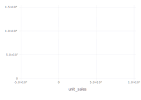

In [27]:
plot(trainFrame,x = "unit_sales",Geom.histogram)

_Figure 1: Distribution of Unit Sales._

We see that most of our unit sales look to be rather small with a large prtion of them being astronomically big! Let's try to predict the log of unit sales at this rate. We also see some days with negative observations. This seems unrealistic; Let's check where our data frame is less that 0 for unit sales.

In [34]:
lessThanZeroFrame = trainFrame[trainFrame[:unit_sales] .< 0,:];

In [36]:
nrow(lessThanZeroFrame)

7795

We see around $7000$ rows featuring a negative return in sales. According to [This Kaggle Discussion](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/41559), These should be clipped at 0. We will go about doing that.

In [37]:
trainFrame[trainFrame[:unit_sales] .< 0,:unit_sales] = 0;

In [39]:
trainFrame[:logUnitSales] = log(trainFrame[:unit_sales] .+ 1);

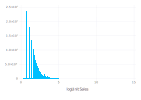

In [40]:
plot(trainFrame,x = "logUnitSales",Geom.histogram)

_Figure 2: Distribution of $\log(unitSales)$._

We see a severre right skewed distribution, with some observations reaching a scale of $e^{10} \approx 22000$ purchases. This should justify the use of a prediction of $\log(unitSales)$ over `unit_sales` proper.

In [41]:
storeNumberCountFrame = by(trainFrame,:store_nbr,nrow)

,store_nbr,x1
1,1,2562153
2,2,2987840
3,3,3401264
4,4,2830554
5,5,2666691
6,6,3089799
7,7,2921204
8,8,3261184
9,9,2773790
10,10,1740482


In [46]:
storeNumberCountFrame = rename(storeNumberCountFrame,:x1,:count);

In [56]:
storeNumberCountFrame = sort(storeNumberCountFrame,cols = :count,
                             rev = true);

In [57]:
storeNumberCountFrame[:rank] = range(1,nrow(storeNumberCountFrame));

In [61]:
#get rank-count plot
storeNumberCountFrame[:density] = (storeNumberCountFrame[:count]
                                    ./ sum(storeNumberCountFrame[:count]));

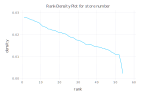

In [65]:
plot(storeNumberCountFrame,x = "rank",y = "density",Geom.line,
     Guide.title("Rank-Density Plot for store number"))

_Figure 3: Rank-Density Plot for Store Number._

We see a relatively gradual decrease in value for rank, which suggests that we don't have extreme inequality among stores being considered.

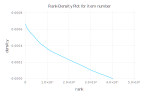

In [66]:
#get rank density plot for products
itemNumberCountFrame = by(trainFrame,:item_nbr,nrow);
itemNumberCountFrame = rename(itemNumberCountFrame,:x1,:count);
itemNumberCountFrame = sort(itemNumberCountFrame,cols = :count,
                             rev = true);
itemNumberCountFrame[:rank] = range(1,nrow(itemNumberCountFrame));
itemNumberCountFrame[:density] = (itemNumberCountFrame[:count]
                                    ./ sum(itemNumberCountFrame[:count]));
plot(itemNumberCountFrame,x = "rank",y = "density",Geom.line,
     Guide.title("Rank-Density Plot for item number"))

_Figure 4: Rank-Density Plot for Item Number._

We see a relatively gradual decrease for item number, which suggests that data sparsity isn't a serious issue in this context.

LoadError: [91mUndefVarError: trainFrame not defined[39m